# Create and run Earthquake Estimator

In [1]:
!nvidia-smi

Tue Jan 22 14:24:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:81:00.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |  15519MiB / 16280MiB |     25%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf
import lstm_estimator
import earthquake_input_fn
from importlib import reload
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
EARTHQUAKE_DATA_DIR = '/workspace/persistent-data/earthquake/tfrecords2'

In [4]:
def reload_tf():
    global lstm_estimator
    global earthquake_input_fn
    for i in range(2):
        import lstm_estimator
        import earthquake_input_fn
        reload(lstm_estimator)
        reload(earthquake_input_fn)
        del lstm_estimator
        del earthquake_input_fn
    import lstm_estimator
    import earthquake_input_fn

In [10]:
reload_tf()

In [6]:
def create_estimator_from_params(batch_size, timesteps, n_feats, feature_columns,
                                 lstm_cell_size, learning_rate, dropout_rate=0.5, label_input_column=None, model_dir=None):
    
    params = {
        'batch_size': batch_size,
        'timesteps': timesteps,
        'n_feats': n_feats,
        'feature_columns': feature_columns,
        'lstm_cell_size': lstm_cell_size,
        'learning_rate': learning_rate,
        'dropout_rate': dropout_rate,
        'label_input_column': label_input_column
    }
    if model_dir is None:
        model_dir = '/workspace/persistent-data/models/%s' % (time.strftime('%Y-%m-%d-%H-%M-%S'))
    estim = tf.estimator.Estimator(model_fn=lstm_estimator.lstm_model_fn,
                                   params=params,
                                   model_dir=model_dir)
    return estim

In [7]:
BATCH_SIZE=64
TIMESTEPS=32
LSTM_CELL_SIZE=[128, 64]
LEARNING_RATE=0.000075

In [11]:
estimator = create_estimator_from_params(batch_size=BATCH_SIZE,
                                         timesteps=TIMESTEPS,
                                         n_feats=1,
                                         feature_columns=[tf.feature_column.numeric_column(key='acousticdata',
                                                                                           dtype=tf.int64,
                                                                                           shape=(BATCH_SIZE, TIMESTEPS))],
                                         lstm_cell_size=LSTM_CELL_SIZE,
                                         learning_rate=LEARNING_RATE)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_model_dir': '/workspace/persistent-data/models/2019-01-22-09-41-41', '_task_id': 0, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd08c90c358>, '_tf_random_seed': None, '_evaluation_master': '', '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_eval_distribute': None, '_protocol': None, '_train_distribute': None, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_master': '', '_log_step_count_steps': 100, '_task_type': 'worker', '_device_fn': None, '_save_summary_steps': 100}


In [13]:
DISTINCT_BATCHES = 100
STEPS_PER_BATCH = int(4096/TIMESTEPS)
TOTAL_STEPS = DISTINCT_BATCHES * STEPS_PER_BATCH
print('running estimator for %d steps' % TOTAL_STEPS)
estimator.train(input_fn=lambda: earthquake_input_fn.earthquake_input_fn2(EARTHQUAKE_DATA_DIR,
                                                                          BATCH_SIZE,
                                                                          TIMESTEPS,
                                                                          scales=['1e1', '1e0'],
                                                                          traintest='train'),
                steps=TOTAL_STEPS)

running estimator for 12800 steps
INFO:tensorflow:Calling model_fn.
FEATURES
{'acousticdata': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=int64>}
--------------------
LABELS
Tensor("IteratorGetNext:1", shape=(?, ?), dtype=float64, device=/device:CPU:0)
--------------------
MODE
train
--------------------
PARAMS
{'batch_size': 64, 'lstm_cell_size': [128, 64], 'n_feats': 1, 'label_input_column': None, 'feature_columns': [_NumericColumn(key='acousticdata', shape=(64, 32), default_value=None, dtype=tf.int64, normalizer_fn=None)], 'learning_rate': 7.5e-05, 'timesteps': 32, 'dropout_rate': 0.5}
--------------------
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /workspace/persistent-data/models/2019-01-22-09-41-41/model.ckpt-1024
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1024 into /workspace/pe

We just completed one full epoch through the training data. Let's see how we're doing.

In [14]:
PRED_BATCHES = 1
TOTAL_PRED_FILES = PRED_BATCHES * BATCH_SIZE
feats_tensor = earthquake_input_fn.earthquake_input_fn2_prediction(EARTHQUAKE_DATA_DIR,
                                                                   BATCH_SIZE,
                                                                   TIMESTEPS,
                                                                   num_files=TOTAL_PRED_FILES,
                                                                   scales=['1e0', '1e1'],
                                                                   traintest='test')

In [15]:
N_sub_batches = int(4096/TIMESTEPS)
labels = np.ndarray((TOTAL_PRED_FILES, 4096))
feats = np.ndarray((TOTAL_PRED_FILES, 4096))
with tf.Session() as sess:
    for batchnum in range(PRED_BATCHES):
        for i in range(N_sub_batches):
            f = sess.run(feats_tensor)
            feats[batchnum*BATCH_SIZE:(batchnum+1)*BATCH_SIZE,i*TIMESTEPS:(i+1)*TIMESTEPS] = f['acousticdata']
            labels[batchnum*BATCH_SIZE:(batchnum+1)*BATCH_SIZE,i*TIMESTEPS:(i+1)*TIMESTEPS] = f['tminus']

In [16]:
reload_tf()
#estimator = create_estimator_from_params(BATCH_SIZE,
#                                         TIMESTEPS,
#                                         1,
#                                         feature_columns=[tf.feature_column.numeric_column(key='acousticdata',
#                                                                                           dtype=tf.int64,
#                                                                                           shape=(BATCH_SIZE, TIMESTEPS))],
#                                         lstm_cell_size=LSTM_CELL_SIZE,
#                                         learning_rate=LEARNING_RATE,
#                                         model_dir='/workspace/persistent-data/models/2019-01-21-21-18-12')
predictions = estimator.predict(lambda: earthquake_input_fn.earthquake_input_fn2_prediction(EARTHQUAKE_DATA_DIR,
                                                                                            BATCH_SIZE,
                                                                                            TIMESTEPS,
                                                                                            num_files=TOTAL_PRED_FILES,
                                                                                            scales=['1e0', '1e1'],
                                                                                            traintest='test'),
                                yield_single_examples=False)

In [17]:
mae = 0.0
preds = np.ndarray((TOTAL_PRED_FILES, 4096))

for i, p in enumerate(predictions):
    batchidx = int(i / N_sub_batches)
    tsidx = i % N_sub_batches
    
    bs = batchidx * BATCH_SIZE
    ts = tsidx * TIMESTEPS
    preds[bs:bs+BATCH_SIZE,ts:ts+TIMESTEPS] = p['pred']

INFO:tensorflow:Calling model_fn.
FEATURES
{'acousticdata': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=int64>, 'tminus': <tf.Tensor 'IteratorGetNext:1' shape=(?, ?) dtype=float64>}
--------------------
LABELS
None
--------------------
MODE
infer
--------------------
PARAMS
{'batch_size': 64, 'lstm_cell_size': [128, 64], 'n_feats': 1, 'label_input_column': None, 'feature_columns': [_NumericColumn(key='acousticdata', shape=(64, 32), default_value=None, dtype=tf.int64, normalizer_fn=None)], 'learning_rate': 7.5e-05, 'timesteps': 32, 'dropout_rate': 0.5}
--------------------
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /workspace/persistent-data/models/2019-01-22-09-41-41/model.ckpt-13824
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [18]:
mae = np.abs(labels[:,-1] - preds[:,-1]).sum() / BATCH_SIZE
mse = ((labels[:,-1] - preds[:,-1])**2).sum() / BATCH_SIZE

mae_batch = np.abs(labels - preds).sum() / BATCH_SIZE
mse_batch = ((labels - preds)**2).sum() / BATCH_SIZE
    
print('mae: %.5f' % mae)
print('mse: %.5f' % mse)
print('mae batch: %.5f' % mae_batch)
print('mse batch: %.5f' % mse_batch)

mae: 3.61969
mse: 13.97125
mae batch: 14997.44515
mse batch: 59070.61567


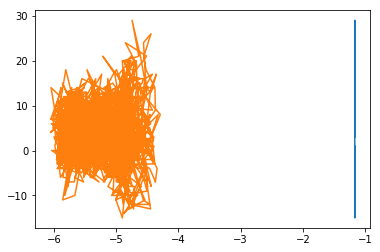

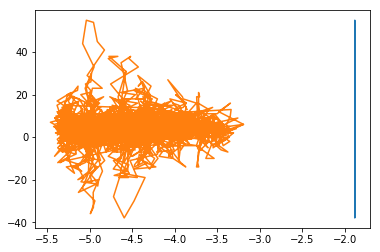

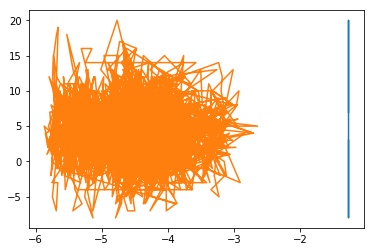

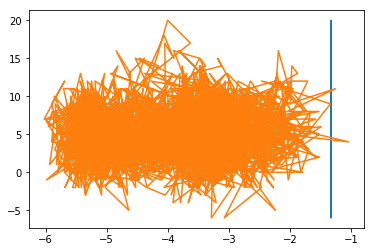

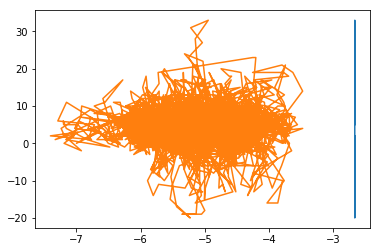

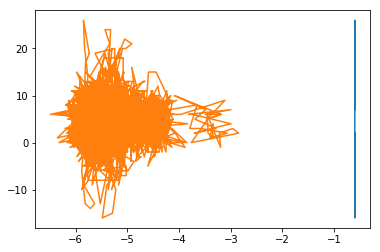

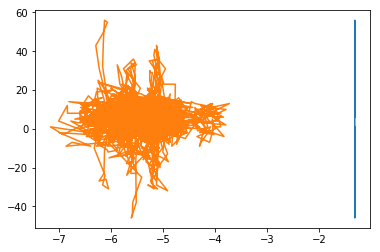

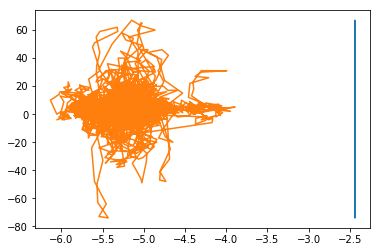

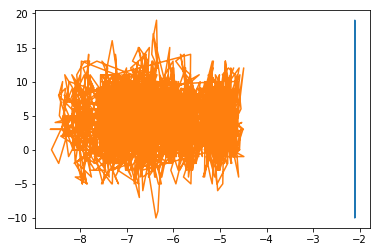

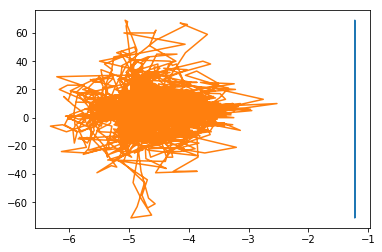

In [21]:
for i in range(10):
    #plt.plot(labels[i,:], feats[i])
    plt.plot(labels[i,:], feats[i,:])
    plt.plot(preds[i,:], feats[i,:])
    plt.show()

In [ ]:
DISTINCT_BATCHES = 1323
STEPS_PER_BATCH = int(4096/TIMESTEPS)
TOTAL_STEPS = DISTINCT_BATCHES * STEPS_PER_BATCH
print('running estimator for %d steps' % TOTAL_STEPS)
estimator.train(input_fn=lambda: earthquake_input_fn.earthquake_input_fn2(EARTHQUAKE_DATA_DIR,
                                                                          BATCH_SIZE,
                                                                          TIMESTEPS,
                                                                          scales=['1e1', '1e0'],
                                                                          traintest='train'),
                steps=TOTAL_STEPS)

running estimator for 169344 steps
INFO:tensorflow:Calling model_fn.
FEATURES
{'acousticdata': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=int64>}
--------------------
LABELS
Tensor("IteratorGetNext:1", shape=(?, ?), dtype=float64, device=/device:CPU:0)
--------------------
MODE
train
--------------------
PARAMS
{'batch_size': 64, 'lstm_cell_size': [128, 64], 'n_feats': 1, 'label_input_column': None, 'feature_columns': [_NumericColumn(key='acousticdata', shape=(64, 32), default_value=None, dtype=tf.int64, normalizer_fn=None)], 'learning_rate': 7.5e-05, 'timesteps': 32, 'dropout_rate': 0.5}
--------------------
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /workspace/persistent-data/models/2019-01-22-09-41-41/model.ckpt-13824
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 13824 into /workspace